In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from feature_extraction import feature
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [14]:
def count_all(model_, train_x, train_y, test_x, test_y, scale_train, scale_test):
    model_norm = model_.fit(train_x, train_y)

    mape_t = mean_absolute_percentage_error(model_norm.predict(test_x), test_y)
    mse_t = mean_squared_error(model_norm.predict(test_x), test_y)
    score_t = model_norm.score(test_x, test_y)
    r2score_t = r2_score(model_norm.predict(test_x), test_y)

    model_scaled = model_.fit(scale_train, train_y)
    mape_scaled_t = mean_absolute_percentage_error(model_scaled.predict(scale_test), test_y)
    mse_scaled_t = mean_squared_error(model_scaled.predict(scale_test), test_y)
    score_scaled_t = model_scaled.score(scale_test, test_y)
    r2score_scaled_t = r2_score(model_scaled.predict(scale_test), test_y)

    res = {'mape_t':mape_t, 'mse_t':mse_t, 'score_t':score_t, 'r2score_t':r2score_t,
           'mape_scaled_t':mape_scaled_t, 'mse_scaled_t':mse_scaled_t, 'score_scaled_t':score_scaled_t, 'r2score_scaled_t':r2score_scaled_t}
    
    return res

In [15]:
df = pd.read_csv('scrap price.csv')
df.head(1)

,ID,symboling,name,fueltypes,aspiration,doornumbers,carbody,drivewheels,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   name              205 non-null    object 
 3   fueltypes         205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumbers       205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheels       205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [17]:
categorials = df.dtypes[df.dtypes == 'object'].index.to_numpy()
categorials

array(['name', 'fueltypes', 'aspiration', 'doornumbers', 'carbody',
       'drivewheels', 'enginelocation', 'enginetype', 'cylindernumber',
       'fuelsystem'], dtype=object)

In [18]:
for col in categorials:
    print(f'{col}: {df[col].unique().shape}')

name: (147,)
fueltypes: (2,)
aspiration: (2,)
doornumbers: (2,)
carbody: (5,)
drivewheels: (3,)
enginelocation: (2,)
enginetype: (7,)
cylindernumber: (7,)
fuelsystem: (8,)


In [19]:
df.drop(['name', 'symboling', 'ID'], axis = 1, inplace = True)

In [20]:
categorials = df.dtypes[df.dtypes == 'object'].index.to_numpy()
for col in categorials:
    print(f'{col}: {df[col].unique()}')

fueltypes: ['gas' 'diesel']
aspiration: ['std' 'turbo']
doornumbers: ['two' 'four']
carbody: ['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
drivewheels: ['rwd' 'fwd' '4wd']
enginelocation: ['front' 'rear']
enginetype: ['dohc' 'ohcv' 'ohc' 'l' 'rotor' 'ohcf' 'dohcv']
cylindernumber: ['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']
fuelsystem: ['mpfi' '2bbl' 'mfi' '1bbl' 'spfi' '4bbl' 'idi' 'spdi']


In [21]:
numerical = set(df.columns) - set(categorials) - set(['price'])
numerical

{'boreratio',
 'carheight',
 'carlength',
 'carwidth',
 'citympg',
 'compressionratio',
 'curbweight',
 'enginesize',
 'highwaympg',
 'horsepower',
 'peakrpm',
 'stroke',
 'wheelbase'}

In [22]:
target = set(['price'])

<Axes: >

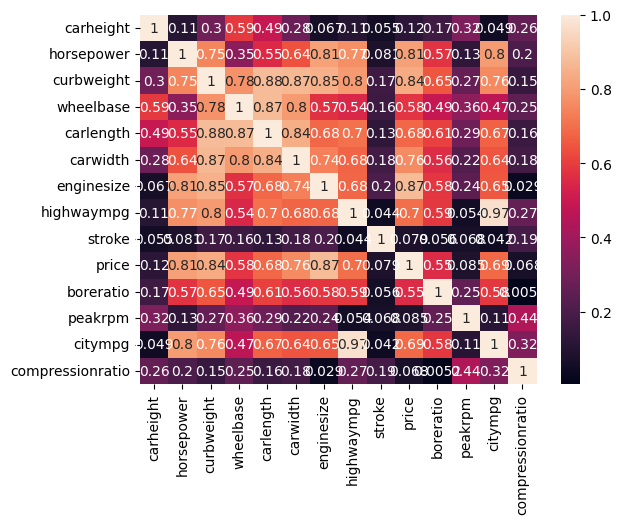

In [23]:
sns.heatmap(np.abs(df[list(target.union(numerical))].corr()),annot = True)

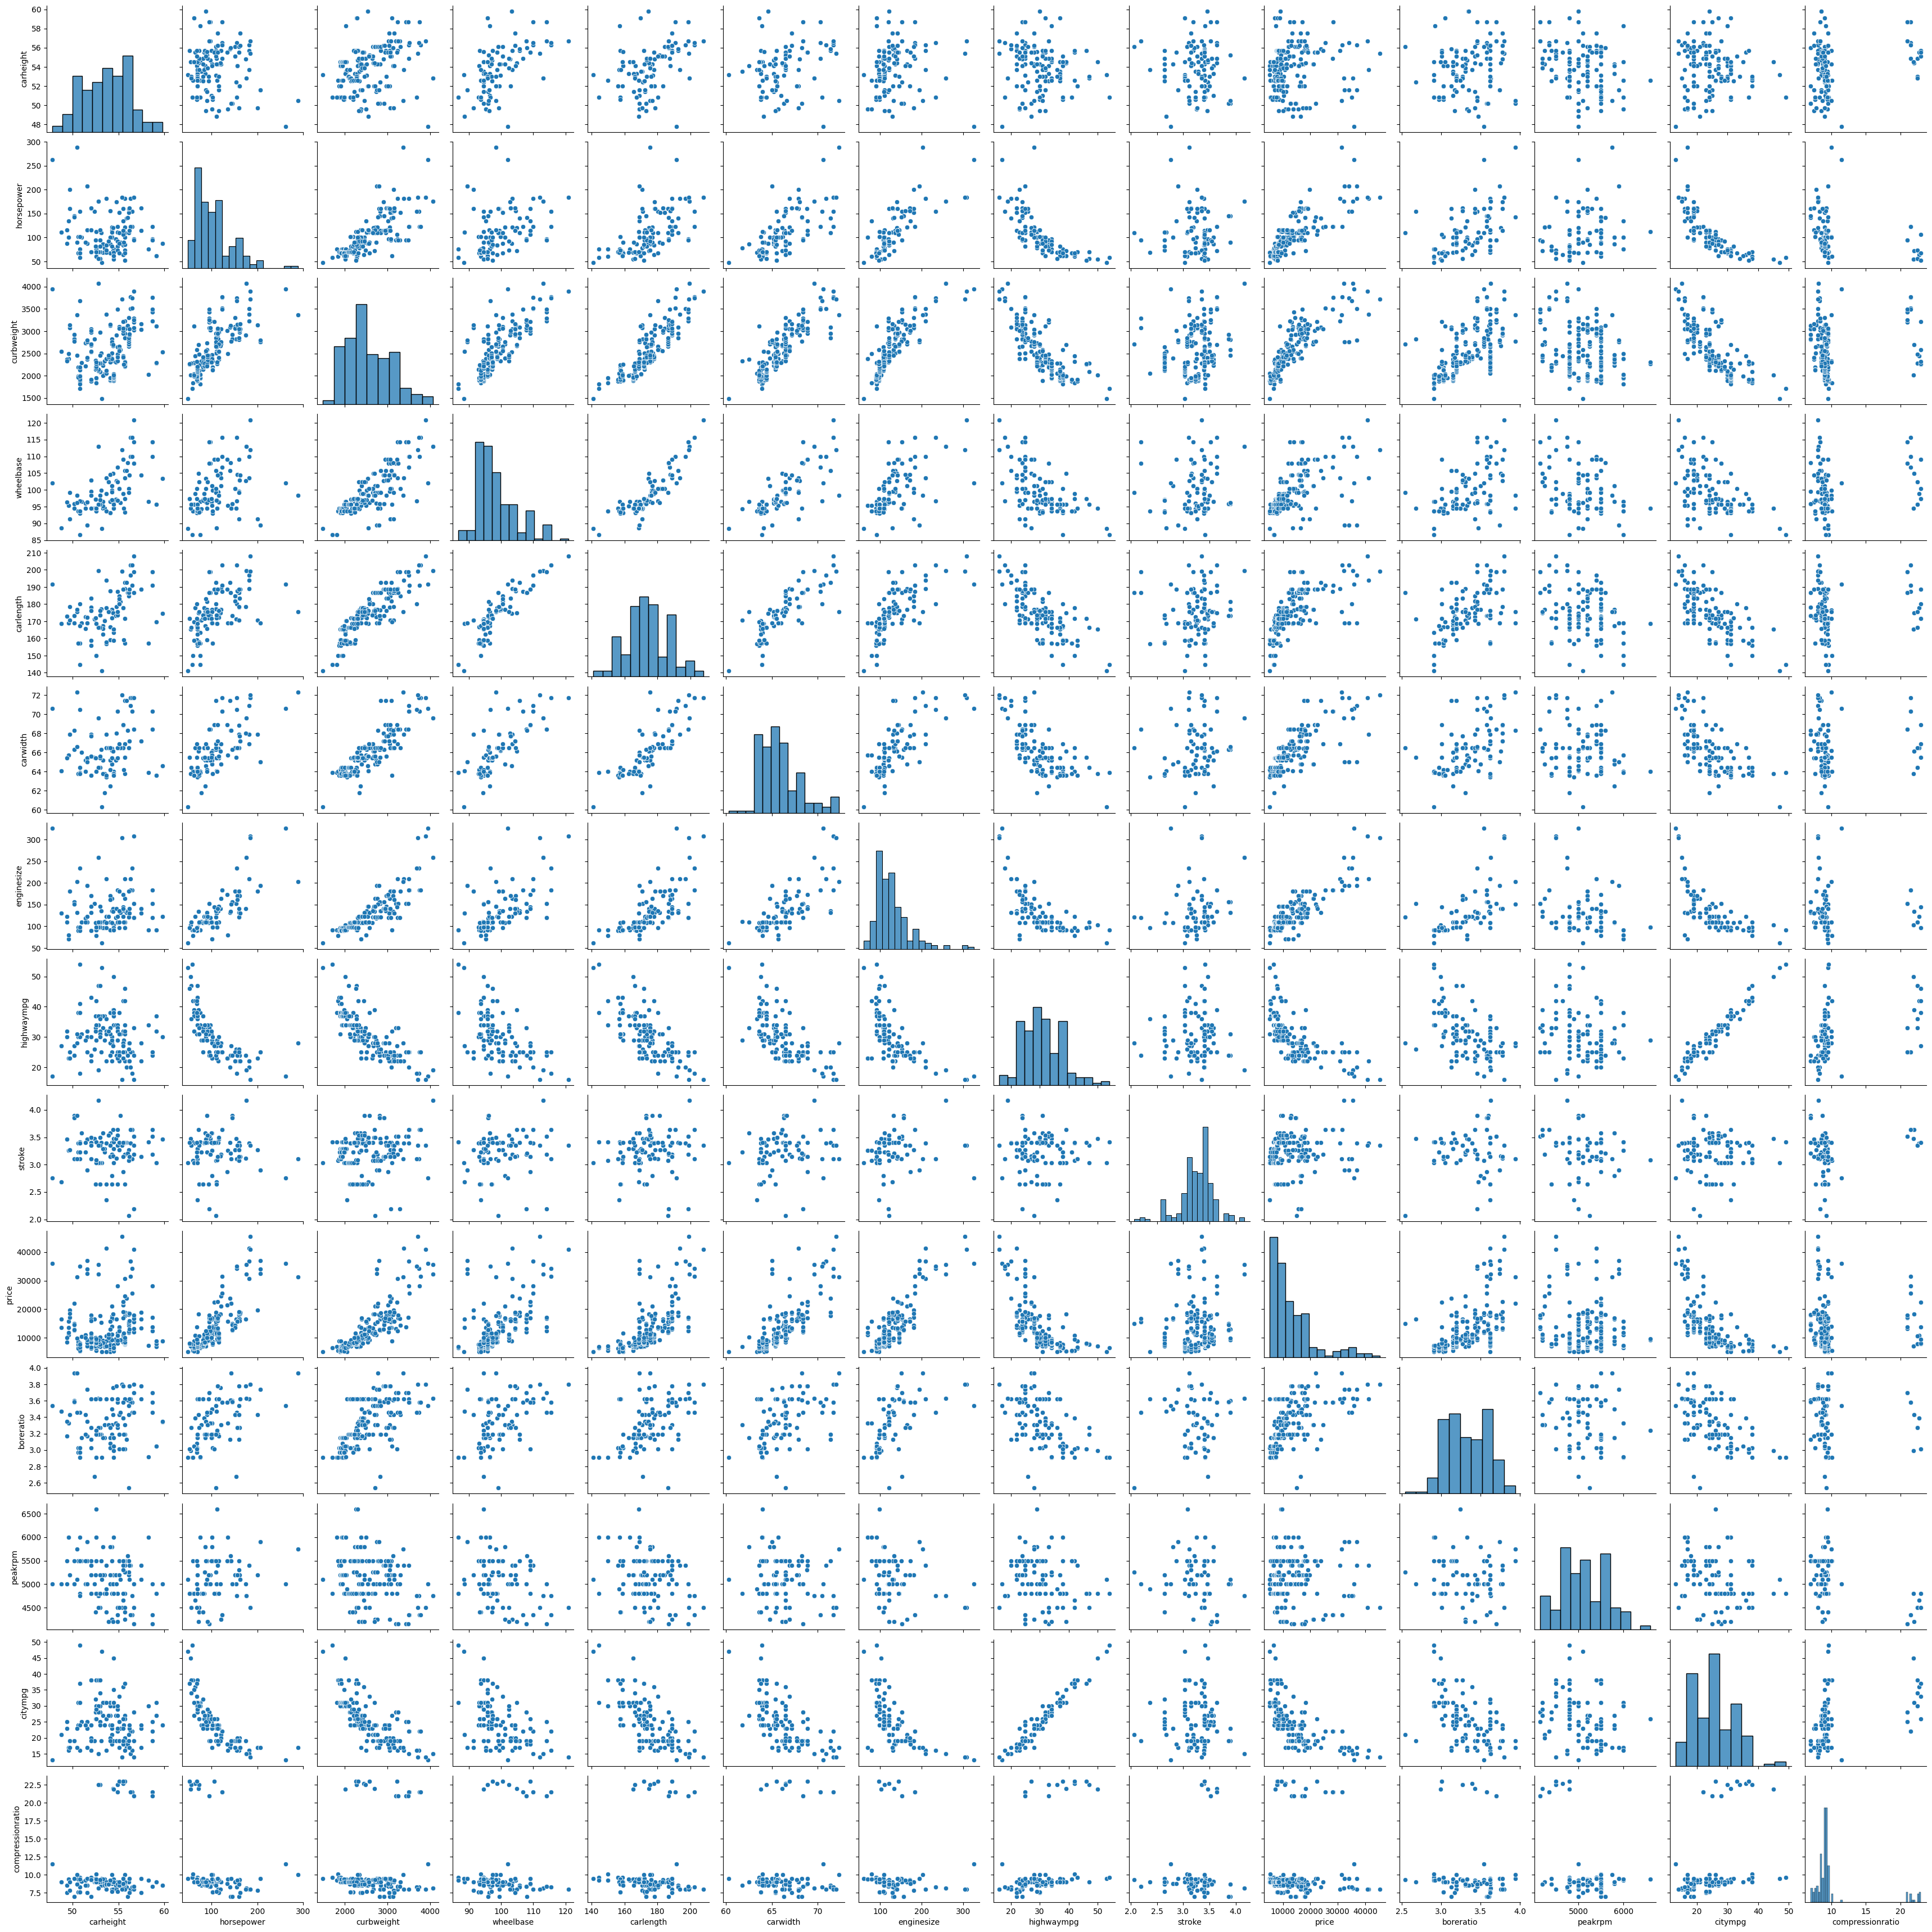

In [24]:
sns.pairplot(df[list(target.union(numerical))])
plt.savefig('pairplot.png')

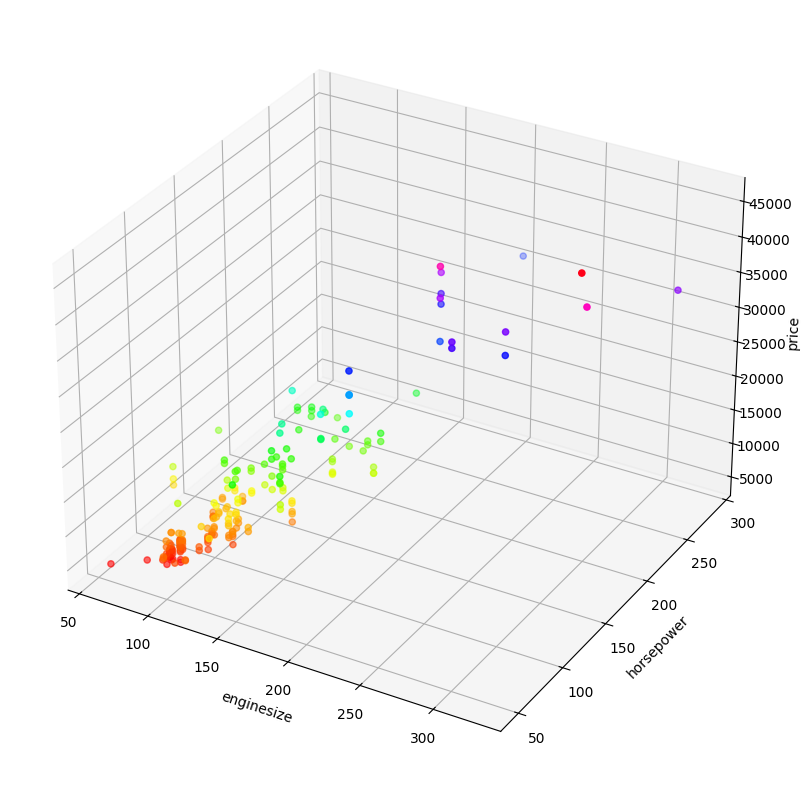

In [25]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

z_points = df.price
x_points = df.enginesize
y_points = df.horsepower
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

ax.set_xlabel('enginesize')
ax.set_ylabel('horsepower')
ax.set_zlabel('price')

plt.show()

In [26]:
for col in list(target.union(numerical)):
    za = zscore(df[col])
    quantilies = df[col].quantile([0.25, 0.75])
    qa = df[~df[col].between(quantilies[0.25], quantilies[0.75])].shape[0]
    print(f'number of outliners based on normal dist, abs: {za[za >= 3].shape[0]}')
    print(f'number of outliners based on normal dist, perc: {za[za >= 3].shape[0]/df.shape[0]: .00%}')
    print(f'number of outliners based on IQR dist, abs: {qa}')
    print(f'number of outliners based on IQR dist, perc: {qa/df.shape[0]: .00%}')

number of outliners based on normal dist, abs: 0
number of outliners based on normal dist, perc:  0%
number of outliners based on IQR dist, abs: 99
number of outliners based on IQR dist, perc:  48%
number of outliners based on normal dist, abs: 2
number of outliners based on normal dist, perc:  1%
number of outliners based on IQR dist, abs: 94
number of outliners based on IQR dist, perc:  46%
number of outliners based on normal dist, abs: 0
number of outliners based on normal dist, perc:  0%
number of outliners based on IQR dist, abs: 101
number of outliners based on IQR dist, perc:  49%
number of outliners based on normal dist, abs: 1
number of outliners based on normal dist, perc:  0%
number of outliners based on IQR dist, abs: 85
number of outliners based on IQR dist, perc:  41%
number of outliners based on normal dist, abs: 0
number of outliners based on normal dist, perc:  0%
number of outliners based on IQR dist, abs: 96
number of outliners based on IQR dist, perc:  47%
number of

# baseline

In [27]:
dummies = pd.get_dummies(df[categorials])
dfcopy = df.join(dummies)
dfcopy.drop(categorials, axis = 1, inplace = True)
dfcopy

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,...,False,False,False,False,False,False,False,True,False,False
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,...,False,False,False,False,False,False,False,True,False,False
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,...,False,False,False,False,False,False,False,True,False,False
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,...,False,False,False,False,False,False,False,True,False,False
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,109.1,188.8,68.9,55.5,2952,141,3.78,3.15,9.5,114,...,False,False,False,False,False,False,False,True,False,False
201,109.1,188.8,68.8,55.5,3049,141,3.78,3.15,8.7,160,...,False,False,False,False,False,False,False,True,False,False
202,109.1,188.8,68.9,55.5,3012,173,3.58,2.87,8.8,134,...,False,False,False,False,False,False,False,True,False,False
203,109.1,188.8,68.9,55.5,3217,145,3.01,3.40,23.0,106,...,False,False,False,False,False,True,False,False,False,False


In [55]:
x = dfcopy.drop(list(target), axis = 1)
y = dfcopy[list(target)].price.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 12)

In [56]:
scaler = StandardScaler()
scaler.fit(x_train.to_numpy()[:,:13])
train_x_norm = scaler.transform(x_train.to_numpy()[:,:13])

train_x_norm = np.concatenate([train_x_norm, x_train.to_numpy()[:,13:]], axis = 1)

scaler = StandardScaler()
scaler.fit(x_test.to_numpy()[:,:13])
test_x_norm = scaler.transform(x_test.to_numpy()[:,:13])

test_x_norm = np.concatenate([test_x_norm, x_test.to_numpy()[:,13:]], axis = 1)

# feature selection

In [57]:
feature1 = feature(dfcopy, 'price')
m1 = feature1.mutual_info_selector(x_train, y_train, 51)
f1 = feature1.f_test_selector(x_train, y_train, 51)
sh1 = feature1.shapley_selection(x_train, y_train, x_test, y_test, LinearRegression(), 51)
pm1 = feature1.permutation_check(x_train, y_train, x_test, y_test, LinearRegression(), 51)

In [58]:
df1 = pd.merge(m1, f1, left_index = True, right_index = True)
df1 = pd.merge(df1, pm1, left_index = True, right_index = True)
df1 = pd.merge(df1, sh1, left_index = True, right_index = True)

df1

,mutual_score,f_p_values,imp_mean,imp_std,shapley_mean
wheelbase,0.451523,2.079185e-15,0.013466,0.005615,354.848829
carlength,0.498566,2.268668e-21,0.079845,0.025751,1434.347777
carwidth,0.712031,1.687971e-33,0.184856,0.040457,1851.08971
carheight,0.200862,1.363995e-01,0.009531,0.002777,204.947718
curbweight,0.914577,5.585269e-39,0.079816,0.017201,1012.120113
enginesize,0.877467,1.272888e-49,0.831685,0.127933,3455.195775
boreratio,0.508122,3.291423e-13,0.023086,0.010428,645.280835
stroke,0.390090,3.576442e-01,0.080934,0.019337,885.907328
compressionratio,0.239826,2.055750e-01,0.206485,0.041096,1145.074356
horsepower,0.910284,1.751493e-33,-0.000017,0.000901,47.07976


In [59]:
df1 = feature.overall_selector(df1, 0.05, 0.05 / 51, 0.60, 1)
def selector_c(x1, x2, x3, x4):
    if sum([x1, x2, x3, x4]) >= 3:
        return 1
    else: return 0
df1['gotIt'] = df1.apply(lambda x: selector_c(x.imp_mean_thr, x.f_p_values_thr,x.mutual_score_thr, x.shapley_mean_thr), axis = 1)
good_values = df1[df1.gotIt == 1].index

In [60]:
x_train_f = x_train[good_values]
x_test_f = x_test[good_values]

x_train_f_scaled = train_x_norm[:,x_train.columns.isin(good_values)]
x_test_f_scaled = test_x_norm[:,x_test.columns.isin(good_values)]

In [61]:
models = [[LinearRegression(), 'linreg'], [DecisionTreeRegressor(), 'tree'],[RandomForestRegressor(), 'forest'], [CatBoostRegressor(silent=True), 'CatBoost']]

In [62]:
resulting_df = pd.DataFrame()

for model__ in models:

    model_name = model__[-1]
    res_st = count_all(model__[0], x_train, y_train, x_test, y_test, train_x_norm, test_x_norm)
    res_ft = count_all(model__[0], x_train_f, y_train, x_test_f, y_test, train_x_norm, test_x_norm)

    resulting_df[model_name] = np.round(np.array([res_st['mape_t'],
                                res_st['score_t'],
                                res_st['r2score_t'],
                                res_st['mape_scaled_t'],
                                res_st['score_scaled_t'], 
                                res_st['r2score_scaled_t'],
                                res_ft['mape_t'],
                                res_ft['score_t'],
                                res_ft['r2score_t'],
                                res_ft['mape_scaled_t'],
                                res_ft['score_scaled_t'], 
                                res_ft['r2score_scaled_t']]),2)
    
resulting_df.index = [  
                        'mape_t_classic',
                        'score_t_classic',
                        'r2score_t_classic',
                        'mape_scaled_t_classic',
                        'score_scaled_t_classic',
                        'r2score_scaled_t_classict',
                        'mape_t_featured',
                        'score_t_featured',
                        'r2score_t_featured',
                        'mape_scaled_t_featured',
                        'score_scaled_t_featured',
                        'r2score_scaled_t_featured'
                    ]

In [63]:
resulting_df

,linreg,tree,forest,CatBoost
mape_t_classic,0.17,0.13,0.11,0.11
score_t_classic,0.84,0.88,0.91,0.91
r2score_t_classic,0.82,0.88,0.90,0.88
mape_scaled_t_classic,0.20,0.16,0.13,0.12
score_scaled_t_classic,0.79,0.71,0.75,0.90
r2score_scaled_t_classict,0.83,0.77,0.80,0.89
mape_t_featured,0.18,0.14,0.12,0.12
score_t_featured,0.77,0.84,0.89,0.88
r2score_t_featured,0.65,0.84,0.87,0.85
mape_scaled_t_featured,0.20,0.15,0.13,0.12


In [64]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

In [65]:
good_values.shape

(7,)

In [66]:
x_train = x_train.to_numpy()[:,:7]
x_test = x_test.to_numpy()[:,:7]
train_x_norm = train_x_norm[:,:7]
test_x_norm = test_x_norm[:,:7]

In [67]:
for model__ in models:

    model_name = model__[-1]+ '_no_dummies'
    res_st = count_all(model__[0], x_train, y_train, x_test, y_test, train_x_norm, test_x_norm)
    res_ft = count_all(model__[0], x_train_f, y_train, x_test_f, y_test, train_x_norm, test_x_norm)

    resulting_df[model_name] = np.round(np.array([res_st['mape_t'],
                                res_st['score_t'],
                                res_st['r2score_t'],
                                res_st['mape_scaled_t'],
                                res_st['score_scaled_t'], 
                                res_st['r2score_scaled_t'],
                                res_ft['mape_t'],
                                res_ft['score_t'],
                                res_ft['r2score_t'],
                                res_ft['mape_scaled_t'],
                                res_ft['score_scaled_t'], 
                                res_ft['r2score_scaled_t']]),2)

In [68]:
resulting_df

,linreg,tree,forest,CatBoost,linreg_no_dummies,tree_no_dummies,forest_no_dummies,CatBoost_no_dummies
mape_t_classic,0.17,0.13,0.11,0.11,0.21,0.14,0.12,0.12
score_t_classic,0.84,0.88,0.91,0.91,0.71,0.83,0.88,0.89
r2score_t_classic,0.82,0.88,0.90,0.88,0.55,0.86,0.88,0.87
mape_scaled_t_classic,0.20,0.16,0.13,0.12,0.21,0.18,0.14,0.13
score_scaled_t_classic,0.79,0.71,0.75,0.90,0.69,0.65,0.77,0.84
r2score_scaled_t_classict,0.83,0.77,0.80,0.89,0.68,0.77,0.81,0.83
mape_t_featured,0.18,0.14,0.12,0.12,0.18,0.13,0.12,0.12
score_t_featured,0.77,0.84,0.89,0.88,0.77,0.85,0.89,0.88
r2score_t_featured,0.65,0.84,0.87,0.85,0.65,0.85,0.87,0.85
mape_scaled_t_featured,0.20,0.15,0.13,0.12,0.21,0.15,0.14,0.13


In [69]:
x_train = poly.fit_transform(x_train)
x_test = poly.fit_transform(x_test)
x_test_f = poly.fit_transform(x_test_f)
x_train_f = poly.fit_transform(x_train_f)

x_train_f_scaled = poly.fit_transform(x_train_f_scaled)
x_test_f_scaled = poly.fit_transform(x_test_f_scaled)
train_x_norm = poly.fit_transform(train_x_norm)
test_x_norm = poly.fit_transform(test_x_norm)

In [70]:
for model__ in models:

    model_name = model__[-1]+ '_no_dummies_poly'
    res_st = count_all(model__[0], x_train, y_train, x_test, y_test, train_x_norm, test_x_norm)
    res_ft = count_all(model__[0], x_train_f, y_train, x_test_f, y_test, train_x_norm, test_x_norm)

    resulting_df[model_name] = np.round(np.array([res_st['mape_t'],
                                res_st['score_t'],
                                res_st['r2score_t'],
                                res_st['mape_scaled_t'],
                                res_st['score_scaled_t'], 
                                res_st['r2score_scaled_t'],
                                res_ft['mape_t'],
                                res_ft['score_t'],
                                res_ft['r2score_t'],
                                res_ft['mape_scaled_t'],
                                res_ft['score_scaled_t'], 
                                res_ft['r2score_scaled_t']]),2)

In [71]:
resulting_df

,linreg,tree,forest,CatBoost,linreg_no_dummies,tree_no_dummies,forest_no_dummies,CatBoost_no_dummies,linreg_no_dummies_poly,tree_no_dummies_poly,forest_no_dummies_poly,CatBoost_no_dummies_poly
mape_t_classic,0.17,0.13,0.11,0.11,0.21,0.14,0.12,0.12,0.48,0.14,0.13,0.12
score_t_classic,0.84,0.88,0.91,0.91,0.71,0.83,0.88,0.89,0.41,0.86,0.89,0.89
r2score_t_classic,0.82,0.88,0.90,0.88,0.55,0.86,0.88,0.87,0.52,0.87,0.88,0.87
mape_scaled_t_classic,0.20,0.16,0.13,0.12,0.21,0.18,0.14,0.13,0.60,0.17,0.13,0.16
score_scaled_t_classic,0.79,0.71,0.75,0.90,0.69,0.65,0.77,0.84,-0.20,0.70,0.79,0.82
r2score_scaled_t_classict,0.83,0.77,0.80,0.89,0.68,0.77,0.81,0.83,0.53,0.80,0.82,0.76
mape_t_featured,0.18,0.14,0.12,0.12,0.18,0.13,0.12,0.12,4.39,0.15,0.13,0.11
score_t_featured,0.77,0.84,0.89,0.88,0.77,0.85,0.89,0.88,-3.17,0.81,0.90,0.89
r2score_t_featured,0.65,0.84,0.87,0.85,0.65,0.85,0.87,0.85,0.24,0.81,0.87,0.86
mape_scaled_t_featured,0.20,0.15,0.13,0.12,0.21,0.15,0.14,0.13,0.60,0.17,0.14,0.16


In [72]:
lr = resulting_df[['linreg', 'linreg_no_dummies', 'linreg_no_dummies_poly']]
lr

,linreg,linreg_no_dummies,linreg_no_dummies_poly
mape_t_classic,0.17,0.21,0.48
score_t_classic,0.84,0.71,0.41
r2score_t_classic,0.82,0.55,0.52
mape_scaled_t_classic,0.20,0.21,0.60
score_scaled_t_classic,0.79,0.69,-0.20
r2score_scaled_t_classict,0.83,0.68,0.53
mape_t_featured,0.18,0.18,4.39
score_t_featured,0.77,0.77,-3.17
r2score_t_featured,0.65,0.65,0.24
mape_scaled_t_featured,0.20,0.21,0.60


In [73]:
cb = resulting_df[['CatBoost', 'CatBoost_no_dummies', 'CatBoost_no_dummies_poly']]
cb

,CatBoost,CatBoost_no_dummies,CatBoost_no_dummies_poly
mape_t_classic,0.11,0.12,0.12
score_t_classic,0.91,0.89,0.89
r2score_t_classic,0.88,0.87,0.87
mape_scaled_t_classic,0.12,0.13,0.16
score_scaled_t_classic,0.90,0.84,0.82
r2score_scaled_t_classict,0.89,0.83,0.76
mape_t_featured,0.12,0.12,0.11
score_t_featured,0.88,0.88,0.89
r2score_t_featured,0.85,0.85,0.86
mape_scaled_t_featured,0.12,0.13,0.16


In [74]:
t = resulting_df[['tree', 'tree_no_dummies', 'tree_no_dummies_poly']]
t

,tree,tree_no_dummies,tree_no_dummies_poly
mape_t_classic,0.13,0.14,0.14
score_t_classic,0.88,0.83,0.86
r2score_t_classic,0.88,0.86,0.87
mape_scaled_t_classic,0.16,0.18,0.17
score_scaled_t_classic,0.71,0.65,0.70
r2score_scaled_t_classict,0.77,0.77,0.80
mape_t_featured,0.14,0.13,0.15
score_t_featured,0.84,0.85,0.81
r2score_t_featured,0.84,0.85,0.81
mape_scaled_t_featured,0.15,0.15,0.17


In [75]:
f = resulting_df[['forest', 'forest_no_dummies', 'forest_no_dummies_poly']]

In [76]:
sum([df[col].unique().shape[0] for col in categorials])

38

In [77]:
x_train.shape

(143, 36)

In [78]:
best_score = [lr[lr.index.isin(['score_t_classic', 'score_scaled_t_classic'])].max().index[0],
cb[cb.index.isin(['score_t_classic', 'score_scaled_t_classic'])].max().index[0],
t[t.index.isin(['score_t_classic', 'score_scaled_t_classic'])].max().index[0],
f[f.index.isin(['score_t_classic', 'score_scaled_t_classic'])].max().index[0]]
best_score

['linreg', 'CatBoost', 'tree', 'forest']

In [79]:
best_mape = [lr[lr.index.isin(['mape_t_classic', 'mape_scaled_t_classic'])].max().index[0],
cb[cb.index.isin(['mape_t_classic', 'mape_scaled_t_classic'])].max().index[0],
t[t.index.isin(['mape_t_classic', 'mape_scaled_t_classic'])].max().index[0],
f[f.index.isin(['mape_t_classic', 'mape_scaled_t_classic'])].max().index[0]]
best_mape

['linreg', 'CatBoost', 'tree', 'forest']

In [80]:
best_score_F = [lr[lr.index.isin(['score_t_classic', 'score_t_featured'])].max().index[0],
cb[cb.index.isin(['score_t_classic', 'score_t_featured'])].max().index[0],
t[t.index.isin(['score_t_classic', 'score_t_featured'])].max().index[0],
f[f.index.isin(['score_t_classic', 'score_t_featured'])].max().index[0]]
best_score_F

['linreg', 'CatBoost', 'tree', 'forest']

In [81]:
type(best_mape[0])

str

In [82]:
resulting_df[best_mape]

,linreg,CatBoost,tree,forest
mape_t_classic,0.17,0.11,0.13,0.11
score_t_classic,0.84,0.91,0.88,0.91
r2score_t_classic,0.82,0.88,0.88,0.90
mape_scaled_t_classic,0.20,0.12,0.16,0.13
score_scaled_t_classic,0.79,0.90,0.71,0.75
r2score_scaled_t_classict,0.83,0.89,0.77,0.80
mape_t_featured,0.18,0.12,0.14,0.12
score_t_featured,0.77,0.88,0.84,0.89
r2score_t_featured,0.65,0.85,0.84,0.87
mape_scaled_t_featured,0.20,0.12,0.15,0.13
